# 量子シミュレーションのための量子アルゴリズム

色々なパッケージを使ってみるのも良いと思うので、ここでは Qibo を使ってみる。
`pip install qibo` でインストールできる。

anc: ─H─o──H─M─
0  : ───RX─────


(<Axes: >, <Figure size 240x120 with 1 Axes>)

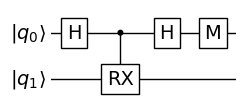

In [2]:
from qibo import Circuit
import qibo
from qibo.ui import plot_circuit
qubits = {"anc": 0, "0": 1}
gate = qibo.gates.RX(qubits["0"], theta=1.).controlled_by(qubits["anc"])
c = Circuit(wire_names=list(qubits.keys()))
c.add(qibo.gates.H(qubits["anc"]))
c.add(gate)
c.add(qibo.gates.H(qubits["anc"]))
c.add(qibo.gates.M(qubits["anc"]))
c.draw()
plot_circuit(c)

In [3]:
result = c.execute(nshots=100) # execute the circuit with initial state |00000>
print(result.state())
print(result.samples(binary=False))

[Qibo 0.2.16|INFO|2025-03-09 14:25:00]: Using numpy backend on /CPU:0


[0.93879128+0.j         0.        -0.23971277j 0.06120872+0.j
 0.        +0.23971277j]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


# Simulate heisenberg model with QIBO

Trotter 展開を使ってシミュレートする。一応基本に忠実に、CNOT を使って exp(itheta ZZ) などを実装してみる。

(<Axes: >, <Figure size 900x120 with 1 Axes>)

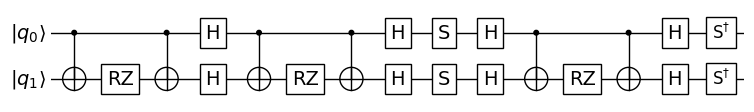

In [4]:
# create circuit, add CNOT Rz CNOT for ZZ interaction, and do similary for XX and YY interaction
from qibo.gates import CNOT, RZ, H, S, SDG
def add_single_heisenberg_interaction(circuit, qubit1, qubit2, theta):
    # ZZ interaction
    circuit.add(CNOT(qubit1, qubit2))
    circuit.add(RZ(qubit2, theta))
    circuit.add(CNOT(qubit1, qubit2))
    # XX interaction
    circuit.add(H(qubit1))
    circuit.add(H(qubit2))
    circuit.add(CNOT(qubit1, qubit2))
    circuit.add(RZ(qubit2, theta))
    circuit.add(CNOT(qubit1, qubit2))
    circuit.add(H(qubit1))
    circuit.add(H(qubit2))
    # YY interaction
    circuit.add(S(qubit1))
    circuit.add(S(qubit2))
    circuit.add(H(qubit1))
    circuit.add(H(qubit2))
    circuit.add(CNOT(qubit1, qubit2))
    circuit.add(RZ(qubit2, theta))
    circuit.add(CNOT(qubit1, qubit2))
    circuit.add(H(qubit1))
    circuit.add(H(qubit2))
    circuit.add(SDG(qubit1))
    circuit.add(SDG(qubit2))

circuit = Circuit(2)
add_single_heisenberg_interaction(circuit, 0, 1, 0.1)
plot_circuit(circuit)

Heisenberg model は 1 次元と仮定して、相互作用強度 `J_list` によって記述する。

In [5]:
import numpy as np
# get numpy Hamiltonian for heisenberg model for reference
def get_numpy_heisenberg_hamiltonian(nspins, J_list):
    from numpy import kron, eye, zeros
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    H = zeros((2**nspins, 2**nspins), dtype=complex)
    for i in range(nspins-1):
        H += J_list[i] * kron(kron(eye(2**i), kron(X, X)), eye(2**(nspins-2-i)))
        H += J_list[i] * kron(kron(eye(2**i), kron(Y, Y)), eye(2**(nspins-2-i)))
        H += J_list[i] * kron(kron(eye(2**i), kron(Z, Z)), eye(2**(nspins-2-i)))
    return H

def add_single_step_heisenberg_evolution(circuit, J_list, t):
    # odd pairs
    for i in range(0, len(J_list), 2):
        add_single_heisenberg_interaction(circuit, i, i+1, J_list[i]*t*2)
    # even pairs
    for i in range(1, len(J_list), 2):
        add_single_heisenberg_interaction(circuit, i, i+1, J_list[i]*t*2)

def get_trotterized_heisenberg_circuit(nspins, J_list, t, nsteps):
    circuit = Circuit(nspins)
    for i in range(nsteps):
        add_single_step_heisenberg_evolution(circuit, J_list, t/nsteps)
    return circuit

(<Axes: >, <Figure size 4500x360 with 1 Axes>)

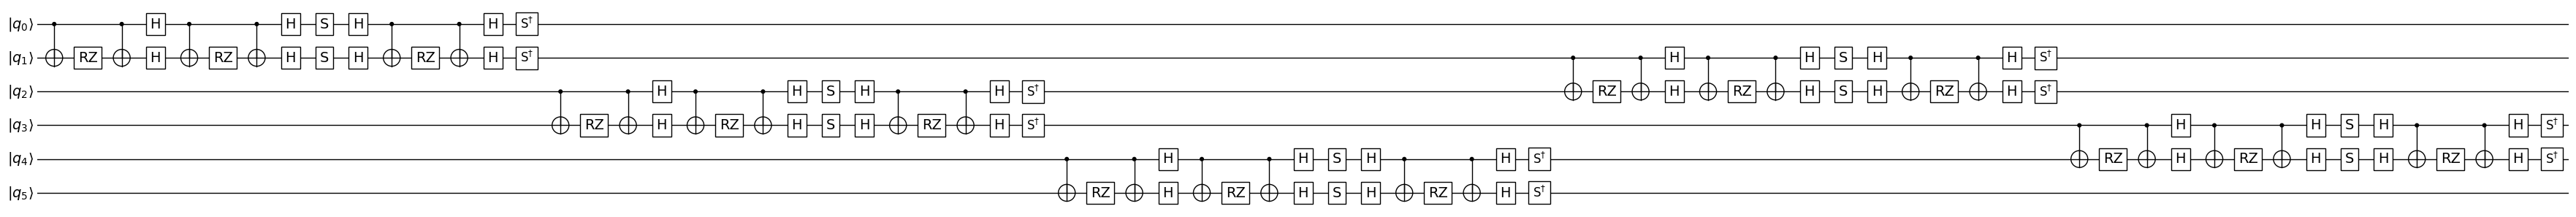

In [6]:
# full heisenberg model evolution
n_spins = 6
n_trotter_steps = 1
t_total = 3
J_list = np.random.rand(n_spins-1)
circuit = get_trotterized_heisenberg_circuit(n_spins, J_list, t_total, n_trotter_steps)
plot_circuit(circuit)

誤差を見てみましょう

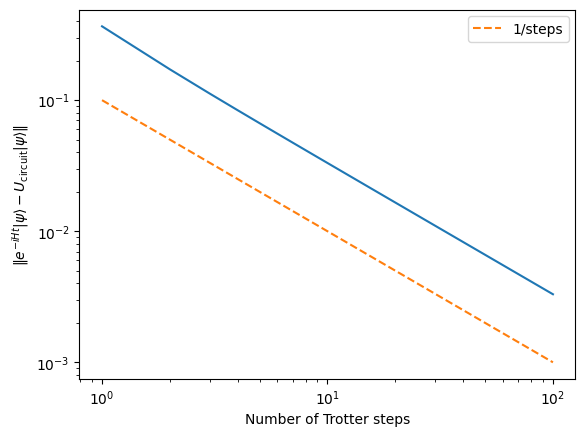

In [7]:
# look at errors between the circuit approximatin and exact evolution
from scipy.linalg import expm
n_spins = 6
t_total = 1
numpy_hamiltonian = get_numpy_heisenberg_hamiltonian(n_spins, J_list)
U_exact = expm(-1j*numpy_hamiltonian*t_total)
initial_state = np.random.rand(2**n_spins)
initial_state /= np.linalg.norm(initial_state)

# look at error at different trotter steps
n_max_trotter = 100
errors = []
for n_trotter_steps in range(1, n_max_trotter+1):
    circuit = get_trotterized_heisenberg_circuit(n_spins, J_list, t_total, n_trotter_steps)
    result = circuit(initial_state)
    error = np.linalg.norm(U_exact @ initial_state - result.state())
    errors.append(error)

import matplotlib.pyplot as plt
plt.plot(range(1, n_max_trotter+1), errors)
plt.plot(np.arange(1, n_max_trotter+1), .1/np.arange(1, n_max_trotter+1), "--", label="1/steps")
plt.xlabel("Number of Trotter steps")
plt.ylabel(r"$\|e^{-iHt}|\psi\rangle - U_{\text{circuit}}|\psi\rangle\|$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

# Hadanard test とフーリエ変換でエネルギースペクトルを見る

まず Hadamard test を実装する量子回路を書きます。初期状態として 010101 を準備する回路も追加しておきます

In [8]:
def get_trotterized_hadamard_test_circuit(nspins, J_list, t, nsteps, imag=False):
    circuit = get_trotterized_heisenberg_circuit(nspins, J_list, t, nsteps)
    hadamard_test_circuit = Circuit(nspins+1, wire_names=list(range(nspins)) + ["anc"])
    hadamard_test_circuit.add(qibo.gates.H(nspins))
    for i in range(0, nspins, 2):
        hadamard_test_circuit.add(qibo.gates.X(i))
    for gate in circuit.queue:
        if gate.name == "rz":
            hadamard_test_circuit.add(gate.controlled_by(nspins))
        else:
            hadamard_test_circuit.add(gate)
    # imaginary part
    if imag:
        hadamard_test_circuit.add(qibo.gates.S(nspins))
    hadamard_test_circuit.add(qibo.gates.H(nspins))
    hadamard_test_circuit.add(qibo.gates.M(nspins))
    return hadamard_test_circuit
get_trotterized_hadamard_test_circuit(6, J_list, 1, 1).draw()

0  :     ─X─o────o─H─o────o─H─S─H─o────o─H─SDG───────────────────────────────── ...
1  :     ───X─RZ─X─H─X─RZ─X─H─S─H─X─RZ─X─H─SDG───────────────────────────────── ...
2  :     ─X───|────────|────────────|──────────o────o─H─o────o─H─S─H─o────o─H─S ...
3  :     ─────|────────|────────────|──────────X─RZ─X─H─X─RZ─X─H─S─H─X─RZ─X─H─S ...
4  :     ─X───|────────|────────────|────────────|────────|────────────|─────── ...
5  :     ─────|────────|────────────|────────────|────────|────────────|─────── ...
anc:     ─H───o────────o────────────o────────────o────────o────────────o─────── ...

0  : ... ────────────────────────────────────────────────────────────────────── ...
1  : ... ──────────────────────────────────────o────o─H─o────o─H─S─H─o────o─H─S ...
2  : ... DG────────────────────────────────────X─RZ─X─H─X─RZ─X─H─S─H─X─RZ─X─H─S ...
3  : ... DG──────────────────────────────────────|────────|────────────|─────── ...
4  : ... ───o────o─H─o────o─H─S─H─o────o─H─SDG───|────────|────────────|───

t を変化させながら実行して、エネルギースペクトルを見てみます。

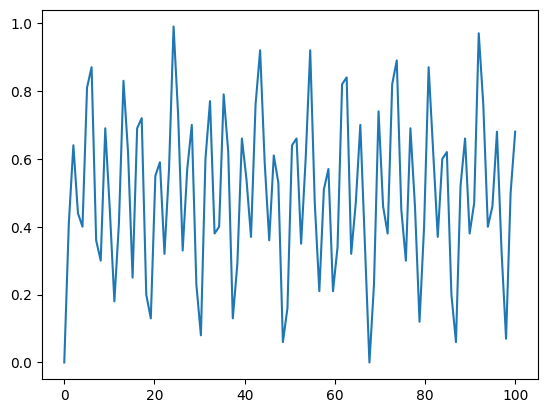

In [15]:
# Execute hadamard test at different times
n_spins = 3
n_trotter_steps = 100
t_max = 100
n_time = 100
J_list = np.random.rand(n_spins-1)
times = np.linspace(0, t_max, n_time)
results = []
results_imag = []
for t in times:
    circuit = get_trotterized_hadamard_test_circuit(n_spins, J_list, t, n_trotter_steps, imag=False)
    result = circuit.execute(nshots=100)
    circuit = get_trotterized_hadamard_test_circuit(n_spins, J_list, t, n_trotter_steps, imag=True)
    result_imag = circuit.execute(nshots=100)
    results.append(result)
    results_imag.append(result_imag)

# plot results
output = []
for result, result_imag in zip(results, results_imag):
    output.append(result.samples(binary=False).mean()+result_imag.samples(binary=False).mean()*1j)
plt.plot(times, np.real(output))

[-0.26639851+0.j  0.05999205+0.j  0.10320323+0.j -0.26639851+0.j
  0.10320323+0.j  0.05999205+0.j  0.10320323+0.j  0.10320323+0.j]


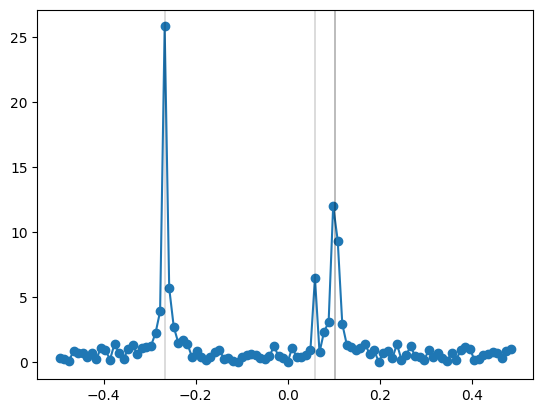

In [16]:
# perform fourier transform and find the frequency
from scipy.fft import fft, fftfreq, fftshift
amplitude = np.abs(fft(output-np.mean(output)))
frequencies = fftfreq(n_time, times[1]-times[0])
plt.plot(fftshift(frequencies), fftshift(amplitude))
plt.scatter(frequencies, amplitude)
# compare with exact frequency
hamiltonian = get_numpy_heisenberg_hamiltonian(n_spins, J_list)
eigenvalues = np.linalg.eigvals(hamiltonian)
frequencies = eigenvalues/2/np.pi
print(frequencies)
for frequency in frequencies:
    plt.axvline(frequency, color="black", linewidth=0.1)
# plt.yscale("log")
plt.show()